### Heart sounds classification with LSTM

##contexte
Cet ensemble de données était à l'origine pour un défi d'apprentissage automatique visant à classer les sons des battements cardiaques. Les données ont été recueillies à partir de deux sources : (A) auprès du grand public via l'application iPhone iStethoscope Pro, et (B) à partir d'un essai clinique dans des hôpitaux utilisant le stéthoscope numérique DigiScope.

objectif c'est la classification des sons cardiaques. 
La tâche consiste à produire une méthode permettant de classer les sons cardiaques réels (également appelés « classification des battements »).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dependencies
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os, fnmatch
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
import itertools

In [ ]:
# dossier parent des fichiers son
INPUT_DIR="/content/drive/MyDrive/dataset"

### Échantillon audio par les catégories important


#### 1. Normale
Dans la catégorie Normal, il y a des sons cardiaques normaux et sains

In [ ]:
#charger un audio de normal heart
normal_file=INPUT_DIR+"/set_a/normal__201103101140.wav"

NameError: ignored

In [ ]:
# heart it
ipd.Audio(normal_file) 

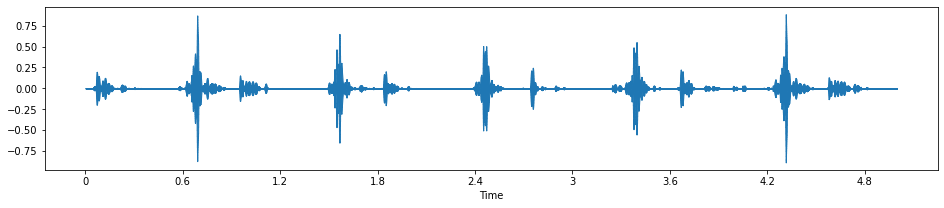

In [ ]:
# Charger l'audio avec Librosa
y, sr = librosa.load(normal_file, duration=5) # le taux d'échantillonnage par défaut est de 22 HZ
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y, sr=sr)

### 2. Murmur
heat murmur sonner comme s'il y avait un bruit de « sifflement, rugissement, grondement ou fluide turbulent »


In [ ]:
#charger un audio de murmur heart
murmur_file=INPUT_DIR+"/set_a/murmur__201108222223.wav"

In [ ]:
ipd.Audio(murmur_file) 

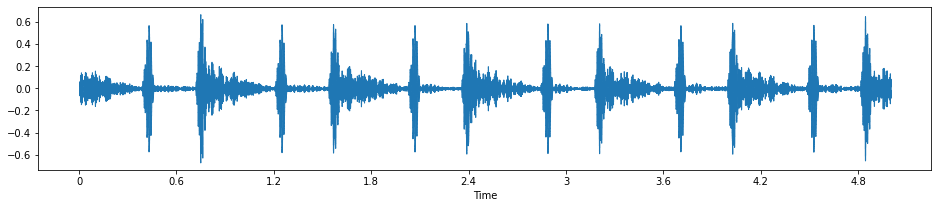

In [ ]:
# Charger l'audio avec Librosa
y2, sr2 = librosa.load(murmur_file,duration=5)  
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y2, sr=sr2)

### 3. Artifact
Dans la catégorie Artefact, il existe une large gamme de sons différents, y compris des cris et des échos de rétroaction, de la parole, de la musique et du bruit. Il n'y a généralement pas de bruits cardiaques discernables, et donc peu ou pas de périodicité temporelle. Cette catégorie est la plus différente des autres. afin que la personne qui collecte les données puisse être invitée à réessayer.

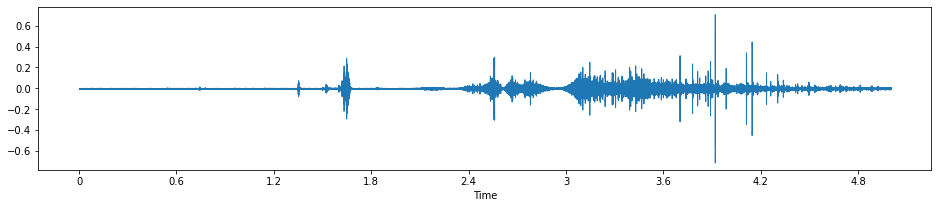

In [ ]:
#charger et tracer l'audio
artifact_file=INPUT_DIR+"/set_a/artifact__201106010559.wav"
y3, sr3 = librosa.load(artifact_file, duration=5)
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y3, sr=sr3)

### Caractéristique sonore : MFCC
Le coefficient cepstral de fréquence Mel (MFCC) est de loin la fonctionnalité la plus réussie utilisée dans le domaine du traitement de la parole.

In [ ]:
# Voici un exemple de génération de mfccs à partir d'un fichier wave
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

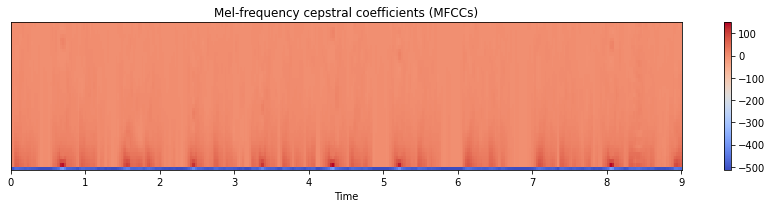

In [ ]:
# Visualisez la série MFCC
# Coefficients cepstraux de fréquence Mel (MFCC)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

In [ ]:
# obtenir des données audio avec fix padding peut également couper certains fichiers
def load_file_data (folder,file_names, duration=10, sr=22050):
    input_length=sr*duration
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # utiliser la technique kaiser_fast pour une extraction plus rapide
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                         
            # extraire la fonction mfcc normalisée des données
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [ ]:
# définir les classes
CLASSES = ['artifact','murmur','normal']

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [ ]:
# chargement de l'ensemble de données (set-a), et  garder-les séparés à des fins de test
MAX_SOUND_CLIP_DURATION=12 # max sound audio 12 second
A_folder=INPUT_DIR+'/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

load file  /content/drive/MyDrive/dataset/set_a/artifact__201105040918.wav
fixing audio lenght : artifact__201105040918.wav
load file  /content/drive/MyDrive/dataset/set_a/artifact__201105041959.wav
fixing audio lenght : artifact__201105041959.wav
load file  /content/drive/MyDrive/dataset/set_a/artifact__201012172012.wav
fixing audio lenght : artifact__201012172012.wav
load file  /content/drive/MyDrive/dataset/set_a/artifact__201106040947.wav
fixing audio lenght : artifact__201106040947.wav
load file  /content/drive/MyDrive/dataset/set_a/artifact__201106040722.wav
fixing audio lenght : artifact__201106040722.wav
load file  /content/drive/MyDrive/dataset/set_a/artifact__201106031558.wav
fixing audio lenght : artifact__201106031558.wav
load file  /content/drive/MyDrive/dataset/set_a/artifact__201105060108.wav
fixing audio lenght : artifact__201105060108.wav
load file  /content/drive/MyDrive/dataset/set_a/artifact__201105280851.wav
fixing audio lenght : artifact__201105280851.wav
load fil

In [ ]:
# chargement de l'ensemble de données (set-b), et  garder-les séparés à des fins de test
B_folder=INPUT_DIR+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal__*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur__*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

load file  /content/drive/MyDrive/dataset/set_b/normal__208_1308159994503_C.wav
fixing audio lenght : normal__208_1308159994503_C.wav
load file  /content/drive/MyDrive/dataset/set_b/normal__183_1308072703477_B.wav
fixing audio lenght : normal__183_1308072703477_B.wav
load file  /content/drive/MyDrive/dataset/set_b/normal__146_1306778707532_D1.wav
load file  /content/drive/MyDrive/dataset/set_b/normal__106_1306776721273_B1.wav
fixing audio lenght : normal__106_1306776721273_B1.wav
load file  /content/drive/MyDrive/dataset/set_b/normal__150_1306776340746_B.wav
fixing audio lenght : normal__150_1306776340746_B.wav
load file  /content/drive/MyDrive/dataset/set_b/normal__179_1307990076841_D.wav
fixing audio lenght : normal__179_1307990076841_D.wav
load file  /content/drive/MyDrive/dataset/set_b/normal__141_1306520154450_B.wav
fixing audio lenght : normal__141_1306520154450_B.wav
load file  /content/drive/MyDrive/dataset/set_b/normal__213_1308245263936_C.wav
fixing audio lenght : normal__213

In [ ]:
#combine set-a and set-b 
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  381 247


In [ ]:
seed = 42
# split data en Train, Validation and Test

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.np_utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.np_utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.np_utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.np_utils.to_categorical(test_y, len(CLASSES)))

In [ ]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (381,)
data size of the array: : 381

audio data shape:  (381, 40, 1)
data size of the array: : 15240

training data shape:  (243, 40, 1)
training label shape:  (243, 3)

validation data shape:  (61, 40, 1)
validation label shape:  (61, 3)

test data shape:  (77, 40, 1)
test label shape:  (77, 3)


In [ ]:
# creation du model LSTM
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['acc','mse', 'mae', 'mape'])
model.summary()

Build LSTM RNN model ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# saved model checkpoint file
best_model_file="/content/drive/MyDrive/Colab Notebooks/model3_heartsound.h5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=16
# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

print ("training finised!")

training started..... please wait.

Epoch 1: loss improved from inf to 1.08886, saving model to /content/drive/MyDrive/Colab Notebooks/model3_heartsound.h5

Epoch 2: loss improved from 1.08886 to 1.08458, saving model to /content/drive/MyDrive/Colab Notebooks/model3_heartsound.h5

Epoch 3: loss improved from 1.08458 to 1.08012, saving model to /content/drive/MyDrive/Colab Notebooks/model3_heartsound.h5

Epoch 4: loss improved from 1.08012 to 1.07714, saving model to /content/drive/MyDrive/Colab Notebooks/model3_heartsound.h5

Epoch 5: loss improved from 1.07714 to 1.07263, saving model to /content/drive/MyDrive/Colab Notebooks/model3_heartsound.h5

Epoch 6: loss improved from 1.07263 to 1.06901, saving model to /content/drive/MyDrive/Colab Notebooks/model3_heartsound.h5

Epoch 7: loss improved from 1.06901 to 1.06572, saving model to /content/drive/MyDrive/Colab Notebooks/model3_heartsound.h5

Epoch 8: loss improved from 1.06572 to 1.06172, saving model to /content/drive/MyDrive/Colab 

In [ ]:
# Evaluer le model
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0) 
print ("model unlabeled data score   : ", round(score[1]*100), "%")

model train data score       :  70 %
model test data score        :  55 %
model validation data score  :  66 %
model unlabeled data score   :  95 %


Text(0.5, 1.0, 'Accuracy Curves')

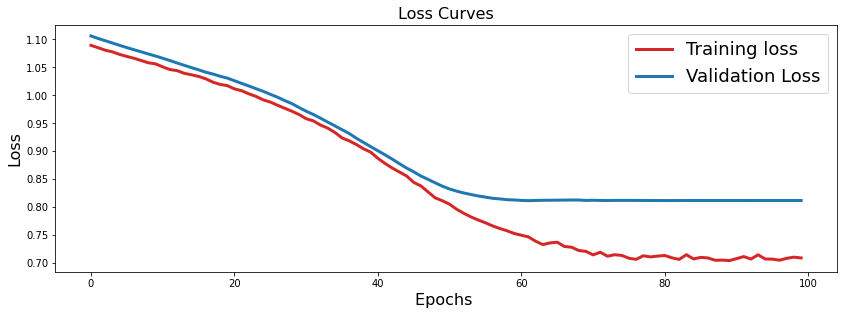

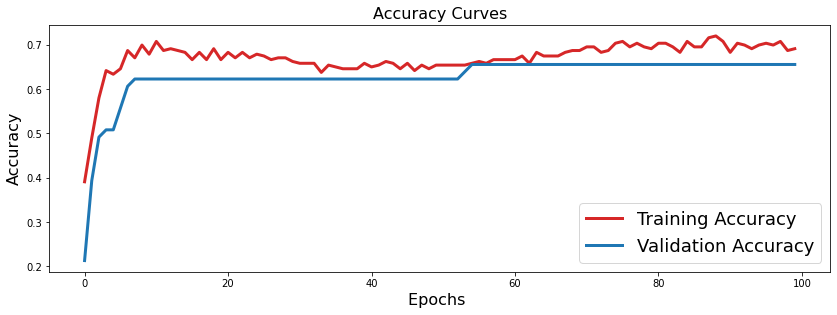

In [ ]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['acc'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_acc'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
pred = model.predict(x_test, verbose=1)
classes_x=np.argmax(pred,axis=1)
# prediction class 
print ("prediction test return :",classes_x[1], "-", int_to_label[classes_x[1]])

4/4 [==============================] - 1s 15ms/step
prediction test return : 2 - normal


In [ ]:
from sklearn.metrics import classification_report
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]

for idx, prediction in enumerate(predictions): 
    y_true.append(CLASSES[np.argmax(y_test[idx])])
    y_pred.append(CLASSES[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

4/4 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00        10
      murmur       0.21      0.33      0.26        18
      normal       0.85      0.75      0.80        91

    accuracy                           0.71       119
   macro avg       0.69      0.69      0.68       119
weighted avg       0.77      0.71      0.73       119



In [ ]:
test = np.array(test_sounds).reshape((len(test_sounds),-1,1))

In [ ]:
y_preds = model.predict(test)
pred = np.argmax(y_preds, axis=1)
for i in range(len(pred)):
    print("prediction test return :", pred[i], "-", int_to_label[pred[i]])

6/6 [==============================] - 1s 15ms/step
prediction test return : 0 - artifact
prediction test return : 2 - normal
prediction test return : 0 - artifact
prediction test return : 0 - artifact
prediction test return : 0 - artifact
prediction test return : 1 - murmur
prediction test return : 0 - artifact
prediction test return : 0 - artifact
prediction test return : 0 - artifact
prediction test return : 0 - artifact
prediction test return : 1 - murmur
prediction test return : 0 - artifact
prediction test return : 1 - murmur
prediction test return : 0 - artifact
prediction test return : 0 - artifact
prediction test return : 0 - artifact
prediction test return : 2 - normal
prediction test return : 0 - artifact
prediction test return : 2 - normal
prediction test return : 2 - normal
prediction test return : 0 - artifact
prediction test return : 2 - normal
prediction test return : 2 - normal
prediction test return : 0 - artifact
prediction test return : 2 - normal
prediction test re

In [ ]:
pred = model.predict(test)
classes_x=np.argmax(pred,axis=1)
# prediction class 
print ("prediction test return :",classes_x[1], "-", int_to_label[classes_x[1]])

6/6 [==============================] - 0s 15ms/step
prediction test return : 0 - artifact
